<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline

from sklearn.metrics import jaccard_score #use as jaccard_score(y_test,yhat,pos_label = "PAIDOFF")
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

## Define confusion plotting matrix function

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-01-11 16:09:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2021-01-11 16:09:17 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

bins [ 300.          377.77777778  455.55555556  533.33333333  611.11111111
  688.88888889  766.66666667  844.44444444  922.22222222 1000.        ]


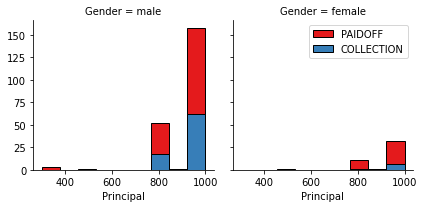

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
print("bins",bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

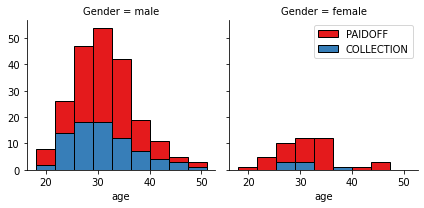

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

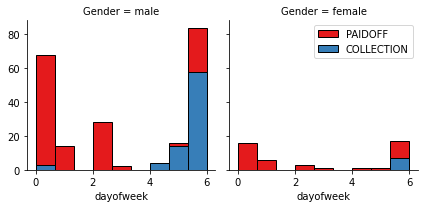

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


## New feature: length of loan

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,loan_length
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,29 days


29 days    176
14 days    139
59 days     12
6 days      11
44 days      5
13 days      3
Name: loan_length, dtype: int64


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,loan_length
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,29


29    176
14    139
59     12
6      11
44      5
13      3
Name: loan_length, dtype: int64


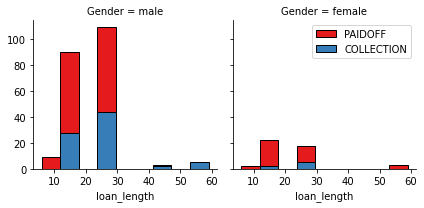

In [12]:
df['loan_length'] = df['due_date'] - df['effective_date']
display(df.head())
print(df['loan_length'].value_counts())

df['loan_length'] = df['loan_length'].dt.days.astype('int16')

display(df.head())
print(df['loan_length'].value_counts())


bins = np.linspace(df.loan_length.min(), df.loan_length.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'loan_length', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [13]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,loan_length
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,29


In [14]:
type(df['dayofweek'].value_counts().sort_index())
df['dayofweek'].value_counts().sort_index()

0     87
1     20
2     31
3      3
4      8
5     31
6    166
Name: dayofweek, dtype: int64

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [15]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,loan_length,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,29,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,29,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,14,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,29,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,29,1


## Convert Categorical features to numerical values

Lets look at gender:

In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [17]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,loan_length,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,29,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,29,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,14,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,29,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,29,1


## One Hot Encoding  
#### How about education?

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [21]:
Feature['college'].sum()

149

### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [23]:
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [24]:
y = df['loan_status'].values
y[0:10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [25]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# 
# My Custom data processing pipeline

In [26]:
from IPython.display import display, HTML

def proccess_df(df, use_custom_processing = False, verbose = True):
    """
    Processes a df and returns feature set X and labels y.
    The point is to have single function for the full data processing pipeline 
    in order to process the training and test data in exactly the same  way.
    """
    
    #df.dropna()  in this case there arent any NaNs in the data

    # Convert to date time object 
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])

    # Print some info about data
    if(verbose):
        print("Number of each target class in data set:")
        print(df['loan_status'].value_counts())
        print("Data loaded and dates converted to time object:")
        display(df.head())
    
    #Convert target field into numeric values (COLLECTION --> 0, PAIDOFF --> 1)
    le_loan = preprocessing.LabelEncoder()
    le_loan.fit(['COLLECTION','PAIDOFF'])
    df['loan_status'] = le_loan.transform(df['loan_status']) 
    #or could have done:
    #df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
    if(verbose):
        print("Converted target field into numeric values")
        display(df.head())
        print("Number of each target class in data set:")
        print(df['loan_status'].value_counts())

    # Pre-processing:  Feature selection/extraction
    # Add dayofweek column
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    if(verbose):
        print("Added a column 'dayofweek':")
        display(df.head())

    # Add weekend column
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    if(verbose):
        print("Added a column 'weekend':")
        display(df.head())
    
    # Add loan_length column (wont actually use because it actually makes predictions worse. but was worth a try)
    df['loan_length'] = df['due_date'] - df['effective_date']
    df['loan_length'] = df['loan_length'].dt.days.astype('int16')
    if(verbose):
        display(df.head())
        print(df['loan_length'].value_counts())

    # Convert categorical features to numerical values
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    if(verbose):
        print("Converted gender to numerical values")
        display(df.head())

    # Feature selection and One Hot Encoding  
    Feature = df[['Principal','terms','age','Gender','weekend']]  #including 'loan_length' would actually make predictions worse
    Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
    Feature.drop(['Master or Above'], axis = 1,inplace=True)
    if(verbose):
        print("One-hot encoded education and selected features")
        display(Feature.head())
     
    # Define feature sets X and y
    X = Feature
    y = df['loan_status'].values
   
    print("type(X)", type(X))
    print("type(y)", type(y))
    
    return X,y

# Load and process training data

In [27]:
# Load Data From CSV File   
df2 = pd.read_csv('loan_train.csv')

full_X, full_y = proccess_df(df=df2, verbose=False)

type(X) <class 'pandas.core.frame.DataFrame'>
type(y) <class 'numpy.ndarray'>


## Split training data into 'train' and 'test' in order to tune model parameters

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_X, full_y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [29]:
# print("type(X_train)", type(X_train))
# print("type(y_train)", type(y_train))
# print("type(X_test)", type(X_test))
# print("type(y_test)", type(y_test))

## Normalise data

In [30]:
# Normalise the splitted train/test data
scaler = preprocessing.StandardScaler()

# Fit and transform training data
normalized_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# Transform test data with the same scaler
normalized_X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

print("\n Training set - splitted into 'train' and 'test' (for model optimisation):")
display(normalized_X_train.head())
display(normalized_X_test.head())


# Normalise the full training dataset.
# scaler_full_training will later also be used to transform the sepperate test set as well
scaler_full_training = preprocessing.StandardScaler()
normalized_full_X = pd.DataFrame(scaler_full_training.fit_transform(full_X), columns = full_X.columns)
print("\n Full training set (for full fit):")
display(normalized_full_X.head())


 Training set - splitted into 'train' and 'test' (for model optimisation):


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.577307,-0.950026,-0.790867,-0.418040,0.846352,-0.411196,-0.912871,1.233221
1,0.577307,-0.950026,-0.955433,-0.418040,-1.181541,-0.411196,1.095445,-0.810885
2,0.577307,-0.950026,-0.297170,2.392117,-1.181541,-0.411196,1.095445,-0.810885
3,-1.297972,-0.950026,-0.626302,-0.418040,0.846352,-0.411196,-0.912871,1.233221
4,0.577307,0.961612,0.196527,-0.418040,0.846352,-0.411196,1.095445,-0.810885


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.577307,0.961612,-0.132605,-0.41804,0.846352,-0.411196,1.095445,-0.810885
1,-1.297972,-0.950026,-0.132605,-0.41804,0.846352,-0.411196,-0.912871,1.233221
2,0.577307,-0.950026,0.031961,-0.41804,-1.181541,-0.411196,1.095445,-0.810885
3,0.577307,0.961612,-1.119999,-0.41804,-1.181541,-0.411196,-0.912871,1.233221
4,0.577307,0.961612,0.525658,-0.41804,-1.181541,-0.411196,-0.912871,1.233221



 Full training set (for full fit):


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.515785,0.920718,2.331526,-0.420560,-1.205778,-0.381701,1.136394,-0.869681
1,0.515785,0.920718,0.341701,2.377782,-1.205778,2.619854,-0.879977,-0.869681
2,0.515785,-0.959111,-0.653211,-0.420560,-1.205778,-0.381701,-0.879977,1.149847
3,0.515785,0.920718,-0.487392,2.377782,0.829340,-0.381701,-0.879977,1.149847
4,0.515785,0.920718,-0.321573,-0.420560,0.829340,-0.381701,-0.879977,1.149847


## Summary of data 

### Data for optimizing models:
 normalized_X_train, y_train  
 normalized_X_test, y_test  

### Data for training models with optimal parameters:
 normalized_full_X, full_y

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# First test
k = 4        
#Train Model on training data   
neigh = KNeighborsClassifier(n_neighbors=k).fit(normalized_X_train, y_train)
print(neigh)

#Predict test data
yhat = neigh.predict(normalized_X_test)
print("labels in test data:",y_test[25:50])
print("predicted labels   :",yhat[25:50])
print(" Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

KNeighborsClassifier(n_neighbors=4)
labels in test data: [1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1]
predicted labels   : [0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0]
 Test set Accuracy:  0.6826923076923077


## Optimizing choice of k
### Minimizing error-rate and maximizing accuracy score/jaccard score

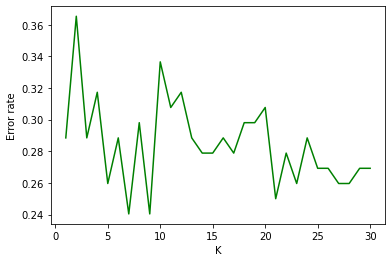

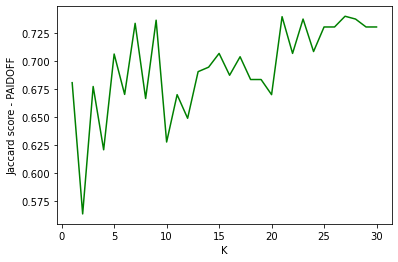

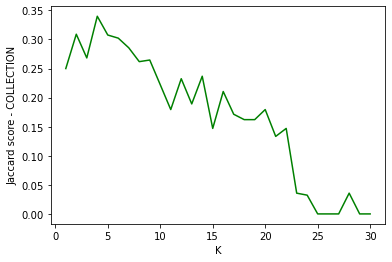

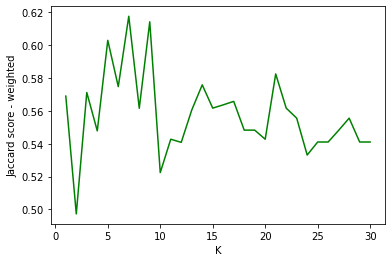

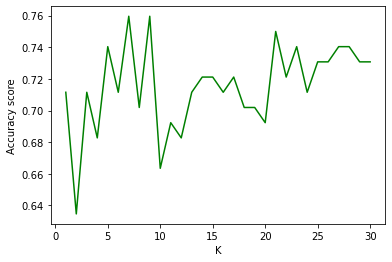

The lowest error rate was with 0.2403846153846154 with k= 7
The highest jaccard_score (PAIDOFF) was with 0.7403846153846154 with k= 27
The highest jaccard_score (COLLECTION) was with 0.34 with k= 4
The highest jaccard_score (weighted) was with 0.6176496375964461 with k= 7
The highest accuracy was with 0.7596153846153846 with k= 7


In [32]:
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score #use as jaccard_score(y_test,yhat,pos_label = "PAIDOFF")

kMax = 31

accuracy = np.zeros((kMax-1))

error_rates = np.zeros((kMax-1))
jaccard = np.zeros((kMax-1))
jaccard2 = np.zeros((kMax-1))
jaccard_weighed = np.zeros((kMax-1))
accuracys = np.zeros((kMax-1))

# Will take some time
for k in list(range(1, kMax)):
    knn = KNeighborsClassifier(n_neighbors = k).fit(normalized_X_train, y_train)
    yhat_i = knn.predict(normalized_X_test)
    
    error_rates[k-1]     = np.mean(yhat_i != y_test)
    jaccard[k-1]         = jaccard_score(y_test,yhat_i,pos_label = 1) #COLLECTION --> 0, PAIDOFF --> 1
    jaccard2[k-1]        = jaccard_score(y_test,yhat_i,pos_label = 0) #COLLECTION --> 0, PAIDOFF --> 1
    jaccard_weighed[k-1] = jaccard_score(y_test,yhat_i, average = 'weighted')
    accuracys[k-1]   = metrics.accuracy_score(y_test, yhat_i)
    
    
plt.plot(range(1,kMax),error_rates,'g')
#plt.legend(('Error rate ', 'Log loss'))
plt.ylabel('Error rate')
plt.xlabel('K')
plt.show()

plt.plot(range(1,kMax),jaccard,'g')
#plt.legend(('Error rate ', 'Log loss'))
plt.ylabel('Jaccard score - PAIDOFF')
plt.xlabel('K')
plt.show()

plt.plot(range(1,kMax),jaccard2,'g')
#plt.legend(('Error rate ', 'Log loss'))
plt.ylabel('Jaccard score - COLLECTION')
plt.xlabel('K')
plt.show()

plt.plot(range(1,kMax),jaccard_weighed,'g')
#plt.legend(('Error rate ', 'Log loss'))
plt.ylabel('Jaccard score - weighted')
plt.xlabel('K')
plt.show()

plt.plot(range(1,kMax),accuracys,'g')
#plt.legend(('Error rate ', 'Log loss'))
plt.ylabel('Accuracy score')
plt.xlabel('K')
plt.show()

print( "The lowest error rate was with", error_rates.min(), "with k=", error_rates.argmin()+1) 

print( "The highest jaccard_score (PAIDOFF) was with", jaccard.max(), "with k=", jaccard.argmax()+1) 
print( "The highest jaccard_score (COLLECTION) was with", jaccard2.max(), "with k=", jaccard2.argmax()+1) 
print( "The highest jaccard_score (weighted) was with", jaccard_weighed.max(), "with k=", jaccard_weighed.argmax()+1) 

print( "The highest accuracy was with", accuracys.max(), "with k=", accuracys.argmax()+1) 

best_k = accuracys.argmax()+1


The best k was found at k=7. jaccard_score (PAIDOFF) is very slightly higher at k=27 than at k=7 but that would an overly generalised model. 

Jaccard for COLLECTION is higher at k = 4. But we are interessted in predicting the PAIDOFF label as good as possible.
So choosing k = 7

## Training the kNN on the full training set (i.e. full_X and full_y)

In [33]:
kNN_optimalK = KNeighborsClassifier(n_neighbors = best_k).fit(normalized_full_X, full_y)
full_yhat = kNN_optimalK.predict(normalized_full_X)

print("Training set Accuracy: ", metrics.accuracy_score(full_y, full_yhat))
print(kNN_optimalK)

Training set Accuracy:  0.8092485549132948
KNeighborsClassifier(n_neighbors=7)


# Decision Tree

## Training the kNN on the splitted training set to find optimal max_depth

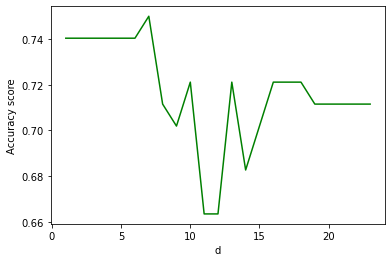

The highest accuracy was with 0.75 with d= 7
labels in test data: [1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1]
predicted labels   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
Test set Accuracy:  0.75


In [34]:
from sklearn.tree import DecisionTreeClassifier

dMax = 24
accuracy_tree = np.zeros((dMax-1))

for d in range(1,dMax):
    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(normalized_X_train, y_train)
    yhat_tree = dTree.predict(normalized_X_test)
    accuracy_tree[d-1] = metrics.accuracy_score(y_test, yhat_tree)


plt.plot(range(1,dMax),accuracy_tree,'g')
plt.ylabel('Accuracy score')
plt.xlabel('d')
plt.show()

print( "The highest accuracy was with", accuracy_tree.max(), "with d=", accuracy_tree.argmax()+1) 
best_depth = accuracy_tree.argmax()+1

dTree = DecisionTreeClassifier(criterion="entropy", max_depth = best_depth).fit(normalized_X_train, y_train)
yhat_tree = dTree.predict(normalized_X_test)
print("labels in test data:",y_test[25:50])
print("predicted labels   :",yhat_tree[25:50])
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_tree))


## Training the tree on the full training set (i.e. full_X and full_y)

In [35]:
tree_optimalD = DecisionTreeClassifier(criterion="entropy", max_depth = best_depth).fit(normalized_full_X, full_y)
full_yhat_tree = tree_optimalD.predict(normalized_full_X)

print("Training set Accuracy: ", metrics.accuracy_score(full_y, full_yhat_tree))
print(tree_optimalD)

Training set Accuracy:  0.8005780346820809
DecisionTreeClassifier(criterion='entropy', max_depth=7)


# Support Vector Machine

In [36]:
from sklearn import svm

kernel_options = ['rbf', 'linear','poly','sigmoid']

for k_opt in kernel_options:
    clf = svm.SVC(kernel=k_opt)
    clf.fit(normalized_X_train, y_train)
    yhat_svn = clf.predict(normalized_X_test)
    print("KERNEL",k_opt)
    #print("labels in test data:",y_test[25:50])
    #print("predicted labels   :",yhat_tree[25:50])
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svn))
    print("Test set F1-Score: ", f1_score(y_test, yhat_svn,pos_label = 1))

KERNEL rbf
Test set Accuracy:  0.75
Test set F1-Score:  0.8555555555555555
KERNEL linear
Test set Accuracy:  0.7403846153846154
Test set F1-Score:  0.850828729281768
KERNEL poly
Test set Accuracy:  0.75
Test set F1-Score:  0.8539325842696629
KERNEL sigmoid
Test set Accuracy:  0.6826923076923077
Test set F1-Score:  0.8114285714285714


RBF gives the highest F1 Score

## Training the SVM on the full training set (i.e. full_X and full_y)

In [37]:
svm_bestKernel = svm.SVC(kernel="rbf")
svm_bestKernel.fit(normalized_full_X, full_y)    

SVC()

# Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s_opt in solver_options:
    LR = LogisticRegression(C=0.01, solver=s_opt)
    LR.fit(normalized_X_train, y_train)
    yhat_LR = LR.predict(normalized_X_test)
    print("SOLVER",s_opt)
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))
    print("Test set F1-Score: ", f1_score(y_test, yhat_LR,pos_label = 1))

SOLVER newton-cg
Test set Accuracy:  0.7403846153846154
Test set F1-Score:  0.850828729281768
SOLVER lbfgs
Test set Accuracy:  0.7403846153846154
Test set F1-Score:  0.850828729281768
SOLVER liblinear
Test set Accuracy:  0.7211538461538461
Test set F1-Score:  0.8361581920903954
SOLVER sag
Test set Accuracy:  0.7403846153846154
Test set F1-Score:  0.850828729281768
SOLVER saga
Test set Accuracy:  0.7403846153846154
Test set F1-Score:  0.850828729281768


Any of the solvers gives the same except liblinear which is worse. 

In [39]:
LR_best = LogisticRegression(C=0.01, solver='newton-cg')
LR_best.fit(normalized_full_X, full_y)

LogisticRegression(C=0.01, solver='newton-cg')

# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_score #use as jaccard_score(y_test,yhat,pos_label = "PAIDOFF")
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [41]:
#You can create a dataframe of the evaluation metrics with their respective values
#compare full_y_test (true) and full_yhat_kNN,  (prediction)

def full_evaluation(full_y_test, full_yhat_kNN):
    """
    Plots confusion matrix, prints classification report and returns jaccard score and f1 score (both with pos_label = 1)
    """
    
    cnf_matrix_kNN = confusion_matrix(full_y_test, full_yhat_kNN, labels=[1,0])
    plot_confusion_matrix(cnf_matrix_kNN, classes=['loan_status=PAIDOFF','loan_status=COLLECTION'],normalize= False,  title='Confusion matrix kNN')
    print (classification_report(full_y_test, full_yhat_kNN))


    #Assuming the scores shall be computed weighted (i.e. for both labels weighted by ) (instead of weighted or for COLLECTION)
    f1_score_kNN_weighted      =      f1_score(full_y_test, full_yhat_kNN,average ='weighted') #pos_label = 'PAIDOFF'  #pos_label = 'COLLECTION'
    print("f1_score_kNN_weighted",f1_score_kNN_weighted)

    #Assuming the scores shall be computed for the PAIDOFF label (instead of weighted or for COLLECTION)
    #Based on what i've read in the forum the teaching staff seems to prefer this 
    # "In the assignment, we have 2 target classes PAIDOFF and COLLECTION, and according to the problem statement 
    # we  are interested in the customers who have PAIDOFF their loans."
    f1_score_kNN      =      f1_score(full_y_test, full_yhat_kNN,pos_label = 1) #pos_label = 'PAIDOFF'  #pos_label = 'COLLECTION'
    jaccard_score_kNN = jaccard_score(full_y_test, full_yhat_kNN,pos_label = 1)

    print("f1_score_kNN     ",f1_score_kNN)
    print("jaccard_score_kNN",jaccard_score_kNN)
    
    return jaccard_score_kNN, f1_score_kNN

First, download and load the test set:

In [42]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-11 16:09:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-11 16:09:22 (81.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [43]:
test_df = pd.read_csv('loan_test.csv')
display(test_df.head())

print("Number of each target class in data set:")
print(test_df['loan_status'].value_counts())

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


Number of each target class in data set:
PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64


### process Test set

In [44]:
full_X_test, full_y_test = proccess_df(df=test_df, verbose=False)

display(full_X_test.head())
display(full_y_test[0:5])

print("shape of full_X_test",full_X_test.shape)
print("shape of full_y_test",full_y_test.shape)

#Normalise using the scaler fitted to the full training data (i.e. scaler_full_training): 
print("Normalise test data with the scaler fitted to the full training data:")
normalised_full_X_test = pd.DataFrame(scaler_full_training.transform(full_X_test), columns = full_X_test.columns)

display(normalised_full_X_test.head())

type(X) <class 'pandas.core.frame.DataFrame'>
type(y) <class 'numpy.ndarray'>


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


array([1, 1, 1, 1, 1])

shape of full_X_test (54, 8)
shape of full_y_test (54,)
Normalise test data with the scaler fitted to the full training data:


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,0.515785,0.920718,3.160619,2.377782,-1.205778,2.619854,-0.879977,-0.869681
1,-5.890524,-1.961686,0.673339,-0.420560,0.829340,-0.381701,-0.879977,-0.869681
2,0.515785,0.920718,1.999888,2.377782,0.829340,-0.381701,1.136394,-0.869681
3,0.515785,0.920718,-0.819029,-0.420560,0.829340,-0.381701,-0.879977,1.149847
4,-1.314589,-0.959111,-0.321573,-0.420560,0.829340,2.619854,-0.879977,-0.869681


## Predict test set with all kNN and evaluate

labels in test data : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
kNN predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
kNN Test set Accuracy:  0.7222222222222222
Confusion matrix, without normalization
[[37  3]
 [12  2]]
              precision    recall  f1-score   support

           0       0.40      0.14      0.21        14
           1       0.76      0.93      0.83        40

    accuracy                           0.72        54
   macro avg       0.58      0.53      0.52        54
weighted avg       0.66      0.72      0.67        54

f1_score_kNN_weighted 0.6704776923582364
f1_score_kNN      0.8314606741573034
jaccard_score_kNN 0.7115384615384616


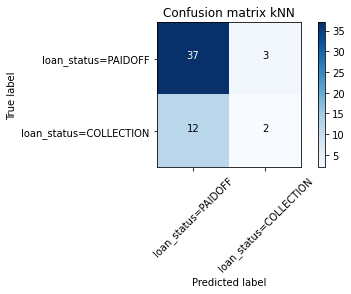

In [45]:
#Predict with kNN
full_yhat_kNN = kNN_optimalK.predict(normalised_full_X_test)

print("labels in test data :",full_y_test[15:50])
print("kNN predicted labels:",full_yhat_kNN[15:50])
print("kNN Test set Accuracy: ", metrics.accuracy_score(full_y_test, full_yhat_kNN))

jaccard_kNN, f1_kNN = full_evaluation(full_y_test, full_yhat_kNN)

## Predict test set with tree and evaluate

labels in test data : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
kNN predicted labels: [1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]
kNN Test set Accuracy:  0.7222222222222222
Confusion matrix, without normalization
[[35  5]
 [10  4]]
              precision    recall  f1-score   support

           0       0.44      0.29      0.35        14
           1       0.78      0.88      0.82        40

    accuracy                           0.72        54
   macro avg       0.61      0.58      0.59        54
weighted avg       0.69      0.72      0.70        54

f1_score_kNN_weighted 0.7001989201477693
f1_score_kNN      0.823529411764706
jaccard_score_kNN 0.7


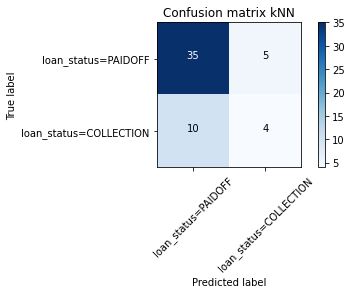

In [46]:
#Predict with tree
full_yhat_tree = tree_optimalD.predict(normalised_full_X_test)

print("labels in test data :",full_y_test[15:50])
print("kNN predicted labels:",full_yhat_tree[15:50])
print("kNN Test set Accuracy: ", metrics.accuracy_score(full_y_test, full_yhat_tree))

jaccard_tree, f1_tree = full_evaluation(full_y_test, full_yhat_tree)

## Predict test set with SVM and evaluate

labels in test data : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
SVM predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
SVM Test set Accuracy:  0.7222222222222222
Confusion matrix, without normalization
[[39  1]
 [14  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      0.97      0.84        40

    accuracy                           0.72        54
   macro avg       0.37      0.49      0.42        54
weighted avg       0.55      0.72      0.62        54

f1_score_kNN_weighted 0.6212664277180406
f1_score_kNN      0.8387096774193549
jaccard_score_kNN 0.7222222222222222


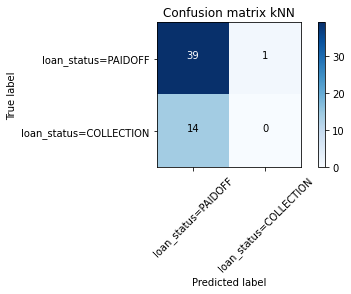

In [47]:
#Predict with kNN
full_yhat_SVM = svm_bestKernel.predict(normalised_full_X_test)

print("labels in test data :",full_y_test[15:50])
print("SVM predicted labels:",full_yhat_SVM[15:50])
print("SVM Test set Accuracy: ", metrics.accuracy_score(full_y_test, full_yhat_SVM))

jaccard_SVM, f1_SVM = full_evaluation(full_y_test, full_yhat_SVM)   

## Predict test set with Logistic regression and evaluate

log_loss_LR 0.5259562030069745
labels in test data : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
SVM predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
SVM Test set Accuracy:  0.7222222222222222
Confusion matrix, without normalization
[[40  0]
 [14  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

f1_score_kNN_weighted 0.6304176516942475
f1_score_kNN      0.851063829787234
jaccard_score_kNN 0.7407407407407407


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


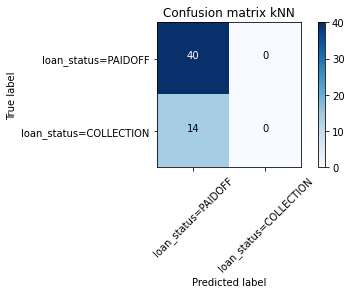

In [48]:
full_yhat_LR      = LR_best.predict(normalised_full_X_test)
full_yhat_LR_prob = LR.predict_proba(normalised_full_X_test)

log_loss_LR = log_loss(full_y_test, full_yhat_LR_prob)
print("log_loss_LR",log_loss_LR)

print("labels in test data :",full_y_test[15:50])
print("SVM predicted labels:",full_yhat_SVM[15:50])
print("SVM Test set Accuracy: ", metrics.accuracy_score(full_y_test, full_yhat_SVM))

jaccard_LR, f1_LR = full_evaluation(full_y_test, full_yhat_LR)   

# Report


## Make Dataframe to report results

In [49]:
#Create dataframe with the results
#jaccard_KNN, f1_score_kNN 
#jaccard_tree, f1_score_tree
data = [['KNN', jaccard_kNN,f1_kNN,"NA"], ['Decsion Tree', jaccard_tree,f1_tree,"NA"], ['SVM',jaccard_SVM,f1_SVM,"NA"], ["LogisticRegression",jaccard_LR, f1_LR,log_loss_LR]] 
  
# Create the pandas DataFrame 
df_results = pd.DataFrame(data, columns = ['Algorithm', 'Jaccard','F1-score','LogLoss']) 

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [50]:
display(df_results)

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.711538,0.831461,NA
1,Decsion Tree,0.700000,0.823529,NA
2,SVM,0.722222,0.838710,NA
3,LogisticRegression,0.740741,0.851064,0.525956


The order of the classifiers from best to worst, for predicting PAIDOFF is: LogisticRegression, SVM, kNN, DecisionTree


However, all classifiers do a bad job at predicting COLLECTION, (worst to best: LogisticRegression, SVM, kNN, DecisionTree), since there is less data available for this label and the Classifiers are mostly tuned for preedicting PAIDOFF. However, predicting PAIDOFF was the focus of the assignment.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.711538| 0.831461 | NA      |
| Decision Tree      | 0.700000| 0.823529 | NA      |
| SVM                | 0.722222| 0.838710 | NA      |
| LogisticRegression | 0.740741| 0.851064 | 0.525957|

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>